In [1]:
from langchain_ollama import ChatOllama
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage

from langchain_groq import ChatGroq

from langgraph.graph import StateGraph, Graph, START, END
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.checkpoint.memory import MemorySaver

import datetime
import pytz

from typing import Union, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

# graph util
from IPython.display import Image, display


def display_graph(graph):
    try:
        display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
    except Exception as e:
        # This requires some extra dependencies and is optional
        print(f"Error: {e}")
        pass

In [2]:
# llm=ChatOllama(
#     verbose=True,
#     model="llama3.2:1b",
#     temperature=0.2,
#     num_ctx=4096
# )

ss_agent_key = "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"
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    api_key=ss_agent_key
)

In [63]:
def get_frienn_char_prompt():
        
    base_char_prompt = f'''You are Frienn, a kind and empathetic virtual companion designed by Friennly, designed to suggest activities to improve users mood and follow up on the activities.

    Behavior Guidelines:

    Be empathetic, respectful, and friendly.
    Respond with brief, short and clear sentences.
    If the user is felling low offering thoughtful suggestions or encouragement if not just chat like a friend
    Never provide medical, legal, or financial advice.

    Activity Suggestion Guidelines:
    Suggest the activities preferred by user if available.
    Do not suggest digital engagement activities or games.
    Ask the user if they want to do the activity now or sometime later.
    Do not overwhelm the user with choices and questions.
    Set a reminder once the user agrees on the activity and time if it is not immediate.

    '''

    return base_char_prompt

In [4]:
def get_superviser_prompt(user_input,select_conv="This is begining of the conversation"):
        
    base_char_prompt = f'''You are an autonoums agent in a mood improvement chat system.

        Based on the current human input and previous exchanges in the conversation pick the best route for the conversation to proceed in.
        
        Previous Exchanges:
        <previous_exchanges>
        {select_conv}
        </previous_exchanges>

        Current Human Input:
        <current_human_input>
        {user_input}
        </current_human_input>
        

        Routes:
        continue_chat : Normal chat route with assistant bot that assists user to improve their mood.
        crisis_helpline : Speaclized route connects user to 24X7 crisis helpline to professionals who will help the human avoid active crisis like suicide.
        set_reminder : Route to set a reminder for the mood improvement activity only if the user agreed.

        If you can not provide answers for sucidial tendencies or harmful pick the crisis helpine route so that user can recieve help from professionals.

        If undecided and there are no harmful intentions always pick continue_chat
    '''

    return base_char_prompt

In [38]:
def get_current_time_ist():
    ist = pytz.timezone('Asia/Kolkata')  # IST timezone
    now_ist = datetime.now(ist) 
    return now_ist.strftime("%Y-%m-%d %H:%M:%S %Z%z")

In [49]:
def base_chat_engine(llm=llm, bot_name="Frienn", bot_char_prompt=None, conversation_history = [], user_input="", exchange=0, preferred_activities=['mo preferred activities']):

    conversation_history = conversation_history
    # exchange = 0
    if bot_char_prompt is None:
        bot_char_prompt = get_frienn_char_prompt()
   
    # while True:
    # user_input = input("You: ")
    print("You: ", user_input)
    # if user_input.lower() in ["exit", "quit", "stop", "q"]:
    #     print(f"{bot_name}: Goodbye. Take care.")
        # break
    preferred_activities = preferred_activities
    
    if exchange == 0:
        chat_prompt_msgs = [SystemMessage(bot_char_prompt), SystemMessage("Introduce about yourselves to the user. Introduction can be of medium size"), HumanMessage(user_input)]
    else:
        conversation_history_pretty = exchanges_pretty(conversation_history)

        chat_prompt_msgs = [SystemMessage(bot_char_prompt), 
        SystemMessage(f"Activities preferred by user: {preferred_activities}"),
        SystemMessage(f"current time: {get_current_time_ist()}"), 
        SystemMessage(f"Conversation Hoistory:<conversation_history>{conversation_history_pretty}</conversation_history>"), 
        HumanMessage(user_input)]
    
    # print(f'''chat_prompt_msgs:{chat_prompt_msgs}''')
    model_response = llm.invoke(chat_prompt_msgs)
    print(f"{bot_name}: ",model_response.content)
    conversation_history.append(HumanMessage(content=user_input))
    conversation_history.append(AIMessage(content=model_response.content))
    exchange += 1

    return conversation_history, user_input, exchange

In [8]:
from pydantic import BaseModel, Field

class SupervisorResponse(BaseModel):
    "Route to proceed in"
    pickedRoute: str = Field(description= "The route to proceed in, ENUM: 'continue_chat', 'crisis_hepline', 'set_remider' ")
    reason: str =Field(description ="Reason for picking the route")

In [9]:
class BotState(TypedDict):
    exchange: int
    # conv_sum: str
    conversation_history: list[AnyMessage]
    preferred_activities: list[str]
    user_input: str
    supervisor_response: SupervisorResponse

In [47]:
from datetime import datetime
class ActivityReminderConfig(BaseModel):
    "Ativity Reminder config"
    activity: str = Field(description="The activity picked to improve user's mood")
    time: str = Field(description="Time at which activity should be done in '%Y-%m-%d %H:%M:%S %Z%z' format")

In [48]:
llm_supervisor_response = llm.with_structured_output(SupervisorResponse)
llm_reminder_config = llm.with_structured_output(ActivityReminderConfig)

In [11]:
def exchanges_pretty(exchanges, summary=False):
    l = []
    c = "assistant"
    if summary:
        c = "assistant"
    for exc in exchanges:
        if exc.type == "ai":
            e = f"{c}: {exc.content}"
        else:
            e = f"{exc.type}: {exc.content}"
        l.append(e)
    return "\n".join(l)

In [12]:
def bot_chat(chat_state:BotState):
    conversation_history = chat_state.get("conversation_history",[])
    exchange = chat_state.get("exchange",0)
    user_input = chat_state["user_input"]
    preferred_activities = chat_state.get("preferred_activities",["no preferences provided"])
                            
    conversation_history,user_input,exchange = base_chat_engine(llm, bot_name="Frienn", bot_char_prompt=None,conversation_history=conversation_history,user_input=user_input, exchange = exchange, preferred_activities=preferred_activities)

    return {
        "conversation_history":conversation_history,
        "user_input":user_input,
        "exchange":exchange
    }

In [69]:
def supervisor(chat_state:BotState):

    conversation_history = chat_state.get("conversation_history",[])
    user_input = chat_state["user_input"]
    exchange = chat_state.get("exchange",0)

    # print("received user-input: ", user_input)

    if len(conversation_history)<6:
        select_conv = conversation_history
    else:
        select_conv = conversation_history[-6:]
    
    prompt = f'''You are an autonoums agent in a mood improvement chat system.

        Based on the current human input and previous exchanges in the conversation pick the best route for the conversation to proceed in.
        
        Previous Exchanges:
        <previous_exchanges>
        {select_conv}
        </previous_exchanges>

        Current Human Input:
        <current_human_input>
        {user_input}
        </current_human_input>
        

        Routes:
        continue_chat : Normal chat route with assistant bot that assists user to improve their mood.
        crisis_helpline : Speaclized route connects user to 24X7 crisis helpline to professionals who will help the human avoid active crisis like suicide.
        set_reminder : Route to set a reminder for the mood improvement activity only if the user agreed on a specific time and activity.

        If you can not provide answers for sucidial tendencies or harmful pick the crisis helpine route so that user can recieve help from professionals.

        If undecided and there are no harmful intentions always pick continue_chat
    '''
    
    supervisor_response  = llm_supervisor_response.invoke(prompt)

    print(f"=====> supervisor Decision: {supervisor_response} <=====")

    if exchange == 0:
        return {"preferred_activities":fetch_user_preferences(), "supervisor_response":supervisor_response}
    
    return {"supervisor_response":supervisor_response}



In [59]:
def set_activity_reminder(chat_state:BotState):
    conversation_history = chat_state.get("conversation_history",[])
    user_input = chat_state["user_input"]

    # print("received user-input: ", user_input)

    if len(conversation_history)<6:
        select_conv = conversation_history
    else:
        select_conv = conversation_history[-6:]

    reminder_config_extraction = f''' 
    Task: Extract the reminder configuration based on the activity and the time it was decided during the conversation.

    current_time: {get_current_time_ist()}

    Conversation Exchanges:
    <conversation>
    {select_conv}
    </conversation>
    
    '''

    reminder_config_extraction_response = llm_reminder_config.invoke(reminder_config_extraction)
    
    # print(f"<==== Setting reminder for {reminder_config_extraction_response.get("activity","None")} at {reminder_config_extraction_response.get("time",None)}")
    print(f"<==== Setting reminder for {reminder_config_extraction_response}")

    return {"reminder_status": True}

In [51]:


def supervisor_edges(chat_state:BotState) -> Literal["Frienn", "crisisHandler", "setReminder"]:
    supervisor_response = chat_state.get("supervisor_response")
    picked_route = supervisor_response.pickedRoute

    if picked_route == 'continue_chat':
        print("picked continue chat")
        return "Frienn"
    elif picked_route == 'crisis_helpline':
        return "crisisHandler"
    elif picked_route =='set_reminder':
        return "setReminder"
    else:
        return "Frienn"



In [52]:
def crisis_handler():
    print("<======called CrsisHandler=====>")
    return "If you are in an active crisis please call 1800-599-0019, a 24/7 toll free helpline launched by the Ministry of Social Justice and Empowerment of India"


In [53]:
def fetch_user_preferences():
   return ['jogging','movies','meditation'] 

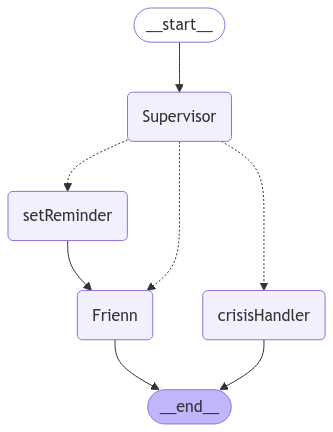

In [64]:

builder = StateGraph(BotState)
builder.add_node("Supervisor",supervisor)
builder.add_node("Frienn",bot_chat)
builder.add_node("setReminder",set_activity_reminder)
builder.add_node("crisisHandler",crisis_handler)

builder.add_edge(START, "Supervisor")
builder.add_conditional_edges("Supervisor", supervisor_edges)
builder.add_edge("Frienn",END)
builder.add_edge("setReminder","Frienn")
builder.add_edge("crisisHandler",END)



memory = MemorySaver()
bot_state_graph = builder.compile(
    checkpointer=memory,
)
config = {"configurable": {"thread_id": "2"}


}

display_graph(bot_state_graph)


SupervisorResponse(pickedRoute='abc', reason='asd')

In [65]:

# while True:
#     try:
#         # Take user input
#         user_input = input("You: ")
#         # Check for exit conditions
#         if user_input.lower() in ["exit", "quit", "bye", "q"]:
#             print(
#                 "Frienn: Take care! Remember, I'm always here if you need someone to talk to."
#             )
#             break

#         events = bot_state_graph.invoke({"user_input": user_input}, config)

#     except Exception as e:
#         print(f"Error: {e}")
#         pass


In [66]:
user_input = "hi"
events = bot_state_graph.invoke({"user_input": user_input}, config)

=====> supervisor Decision: pickedRoute='continue_chat' reason='The user has just initiated the conversation with a greeting, indicating no immediate signs of distress or harmful intentions, so the normal chat route is the most suitable choice.' <=====
picked continue chat
You:  hi
Frienn:  Hello. I'm Frienn, your friendly companion. I'm here to listen, support, and suggest activities to help brighten your day. I'm designed to be empathetic, respectful, and kind. My goal is to help you feel better and improve your mood. I don't offer advice, but I can definitely chat with you like a friend and help you find something fun to do. How are you feeling today?


In [67]:
user_input = "i'm overwhelmed with my work, will have to work for 2 more hours"
events = bot_state_graph.invoke({"user_input": user_input}, config)

=====> supervisor Decision: pickedRoute='continue_chat' reason='The user is expressing feelings of being overwhelmed with work, but there is no indication of suicidal tendencies or harmful intentions. The user can be assisted through normal chat to improve their mood.' <=====
picked continue chat
You:  i'm overwhelmed with my work, will have to work for 2 more hours
Frienn:  That sounds stressful. Would you like to take a short break and do something to relax afterwards, like meditation or a jog? Maybe after you finish work?


In [68]:
user_input = "sounds good may be i'll do it after work"
events = bot_state_graph.invoke({"user_input": user_input}, config)

=====> supervisor Decision: pickedRoute='set_reminder' reason='The user agreed to do a mood improvement activity after work, so setting a reminder is the next logical step to ensure they follow through with their intention.' <=====
<==== Setting reminder for activity='meditation' time='2025-02-01 19:03:09 IST+0530'
You:  sounds good may be i'll do it after work
Frienn:  I'll set a reminder for you to meditate or go for a jog after your work, around 7:03 PM. Would you like to watch a movie later to unwind as well?


In [58]:
user_input = "meditation sounds good, i'll sleep right after it"
events = bot_state_graph.invoke({"user_input": user_input}, config)

=====> supervisor Decision: pickedRoute='set_reminder' reason='The user agreed to go for a jog after work, so setting a reminder for the mood improvement activity is the next logical step.' <=====


AttributeError: 'ActivityReminderConfig' object has no attribute 'get'

In [64]:
user_input = "not now, set a reminder for 1 hour later"
events = bot_state_graph.invoke({"user_input": user_input}, config)

=====> supervisor Decision: pickedRoute='set_reminder' reason='The user has agreed to a mood improvement activity (jogging) and has now requested a reminder for 1 hour later, which aligns with the set_reminder route.' <=====
Setting reminder for {'exchange': 4, 'conversation_history': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}), AIMessage(content="Hello. I'm Frienn, your virtual companion. I'm here to listen and help brighten your day. I can suggest fun activities, chat with you, or just be a friendly ear. How are you feeling today?", additional_kwargs={}, response_metadata={}), HumanMessage(content="i'm overwhelmed with my work", additional_kwargs={}, response_metadata={}), AIMessage(content='That can be really tough. Would you like to take a short break and do something to clear your mind? Maybe some meditation or a short jog outside?', additional_kwargs={}, response_metadata={}), HumanMessage(content='sure lets do some thing', additional_kwargs={}, respon